## Synthetically Composited (SC) data augmentation via Threat Image Projection (TIP).

In [2]:
import cv2
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import skimage.exposure

from utils import seperate_background,rotate_image

In [3]:
# issue cant use the GDXEAY for TIP. No background stuff(Unless we use the existing ones



In [4]:
img_threat = 'data/Threat/B0049/B0049_0019.png'
img_threat = 'data/Threat/B0050/B0050_0002.png'
img_background = 'data/Background/B0044_0003.png'
# img_threat = 'LJJq6.png'

## Threat Signature Transformation


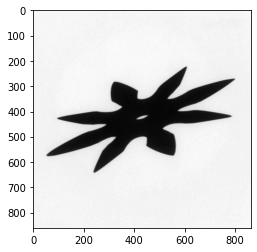

In [10]:
plt.imshow(Image.open(img_threat),cmap='gray')

In [11]:
   
img_clean  = seperate_background(img_threat)
# image with background removed
img_rotated  = rotate_image(img_clean)


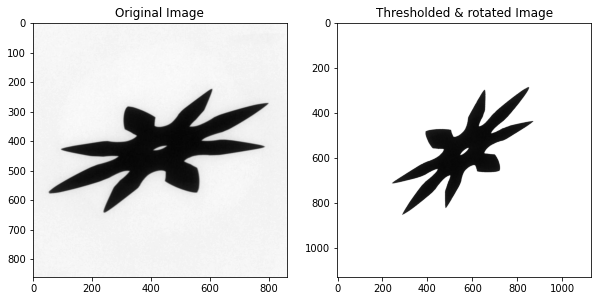

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(Image.open(img_threat),cmap='gray')
plt.subplot(122)
img = Image.open(img_rotated)
plt.title('Thresholded & rotated Image')
plt.imshow(img)

## Image position determination

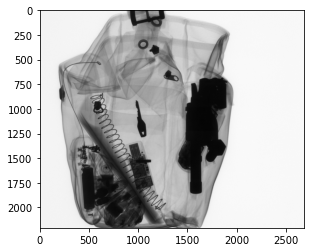

In [32]:
img = cv2.imread(img_background)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_back = img.copy()
plt.imshow(img)

### 1. Binarize image by thresholding

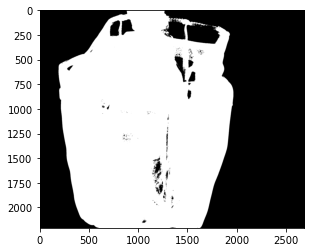

In [19]:
img = cv2.imread(img_background)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret,img_bin = cv2.threshold(img,200,255,cv.THRESH_BINARY_INV)
# ret,img_bin = cv2.threshold(img,210,255,cv.THRESH_BINARY) # This gives same image but with bag in black
plt.imshow(img_bin,cmap='gray')

### 2. Dilation

dilation will grow the foreground pixels.

In [20]:
img.shape

(2208, 2688)

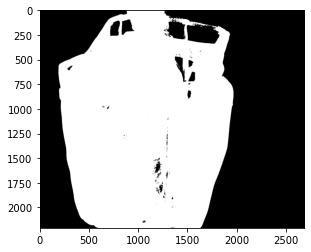

In [21]:

img_dilated = cv2.dilate(img_bin.copy(), None)
plt.imshow( img_dilated,cmap='gray')
plt.show()

### 3.Hole Filling 

In [22]:
img_dilated.shape[:2]

(2208, 2688)

In [23]:
im_floodfill_inv = cv2.bitwise_not(img_dilated)

In [24]:
def FillHole(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    len_contour = len (contours)
    contour_list = []
    for i in range(len_contour):
        drawing = np.zeros_like(mask, np.uint8)  # create a black image
        img_contour = cv2.drawContours(drawing, contours, i, (255, 255, 255), -1)
        contour_list.append(img_contour)

    out = sum(contour_list)
    return out

In [25]:
img_filled = FillHole(img_dilated)
# Hole filling is making results weird

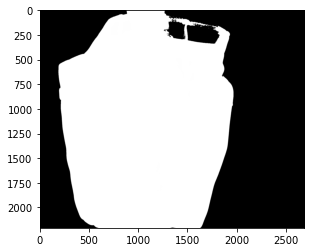

In [26]:
plt.imshow(img_filled,cmap='gray')


### Erosion

an erosion in an image “erodes” the foreground object and makes it smaller. 

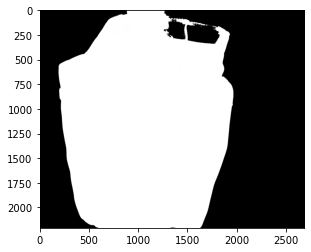

In [27]:

img_eroded = cv2.erode(img_filled.copy(), None)
plt.imshow( img_eroded,cmap='gray')
plt.show()

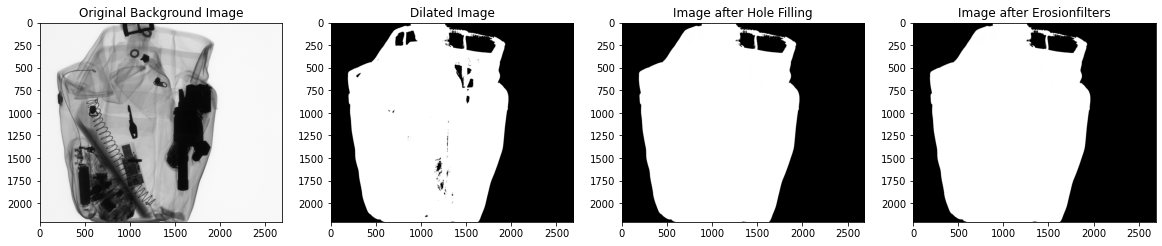

In [39]:
plt.figure(figsize=(20,20))

plt.subplot(141)
plt.title('Original Background Image')
plt.imshow(img_back,cmap='gray')


plt.subplot(142)
plt.title('Dilated Image')
plt.imshow(img_dilated,cmap='gray')
           
plt.subplot(143)
plt.title('Image after Hole Filling')
plt.imshow(img_filled,cmap='gray')

           
plt.subplot(144)
plt.title('Image after Erosionfilters')
plt.imshow(img_eroded,cmap='gray')

##  Image compositing

In [17]:
import random

In [18]:
x,y = img_eroded.nonzero()
max_possible_insertion_points = len(x)

In [68]:
img_rotated

'tmpr.png'

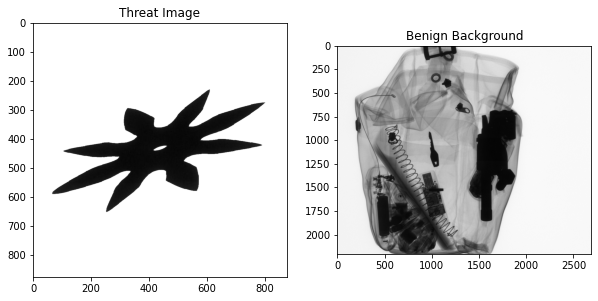

In [71]:
figure=plt.figure(figsize=(10,10))
img = Image.open(img_rotated)
plt.subplot(121)
plt.imshow(img)
plt.title('Threat Image')
background = Image.open(img_background).convert('RGB')
plt.subplot(122)
plt.imshow(background,cmap='gray')
plt.title('Benign Background')
plt.show()

In [20]:
from PIL import Image, ImageDraw

def rect(image, shape):
    draw = ImageDraw.Draw(image)
    colors = ["red", "green", "blue", "yellow",
              "purple", "orange"]
#     shape = [(40, 40), (w + 100, h + 100)]

    draw.rectangle(shape,outline='red',width=10)
    return image



In [49]:
img.size

(1193, 1193)

In [48]:
background.size

(2688, 2208)

In [31]:
count  = 0
W,H = img.size
total_checks = 1
is_not_valid = True
# Finding valid points for insertion
while is_not_valid:
    rand_point = np.random.randint(max_possible_insertion_points)
    print(f"Testing on point = ({x[rand_point]},{y[rand_point]})")
    
    
    ## Check if the position is good.
    ## Algorithm (not given in ppaer,)
    """
    Since we know the size. and our morpohlogicalized image all has 255 in the region of interest
    We can simply check if the end position of the threat image has value 255.
    So we can check the total of 4 coordinates
    """
    positions_to_check  =  [
        (x[rand_point], y[rand_point]), # TOP LEFFT
        (x[rand_point] + W, y[rand_point]), # TOP Right
        (x[rand_point], y[rand_point] + H), # Bottom LEFFT
        (x[rand_point] + W, y[rand_point] + H), # Bottom Right
    ]
    print(f'Bounding box: {positions_to_check}')
    
    for points in positions_to_check:
        # if image superposition is outside the target image. We will get an error. Handle it pythonic way
        # otherwise check all pixels have 255 value
        try:
            if img_eroded[points]==255: # valid point
                is_not_valid = False
            else:
                is_not_valid = True
        except:
            print(f'{points} is outside bounds of Target image. Stopping check for this point')
            is_not_valid = True
            break
    result = "Valid" if is_not_valid==False else "Invalid"
    print(f'Verdict:{result}\n')              
                  
    total_checks+=1
          

   

Testing on point = (1446,1122)
Bounding box: [(1446, 1122), (2639, 1122), (1446, 2315), (2639, 2315)]
(2639, 1122) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (432,786)
Bounding box: [(432, 786), (1625, 786), (432, 1979), (1625, 1979)]
Verdict:Invalid

Testing on point = (1169,1641)
Bounding box: [(1169, 1641), (2362, 1641), (1169, 2834), (2362, 2834)]
(2362, 1641) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (648,1811)
Bounding box: [(648, 1811), (1841, 1811), (648, 3004), (1841, 3004)]
(648, 3004) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (2052,561)
Bounding box: [(2052, 561), (3245, 561), (2052, 1754), (3245, 1754)]
(3245, 561) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (1160,852)
Bounding box: [(1160, 852), (2353, 852), (1160, 2045), (2353, 2045)]
(2353, 8

In [54]:
def get_bounding_box(threat,background):
    """
    Finds best insertion point and returns the bounding box
    Algorithm/Logic


    Since we know the size. and our morpohlogicalized image all has 255 in the region of interest
    We can simply check if the end position of the threat image has value 255.
    So we can check the total of 4 coordinates

    """
    count  = 0
    W,H = threat.size
    total_checks = 1
    is_not_valid = True

    x,y = background.nonzero() # Non zero index
    max_possible_insertion_points = len(x)
    print(max_possible_insertion_points)
    # Finding valid points for insertion
    while is_not_valid:
        rand_point = np.random.randint(max_possible_insertion_points)
        print(f"Testing on point = ({x[rand_point]},{y[rand_point]})")
        
        ## Check if the position is good.
        ## Algorithm (not given in ppaer,)
        """
        Since we know the size. and our morpohlogicalized image all has 255 in the region of interest
        We can simply check if the end position of the threat image has value 255.
        So we can check the total of 4 coordinates
        """
        positions_to_check  =  [
            (x[rand_point], y[rand_point]), # TOP LEFFT
            (x[rand_point] + W, y[rand_point]), # TOP Right
            (x[rand_point], y[rand_point] + H), # Bottom LEFFT
            (x[rand_point] + W, y[rand_point] + H), # Bottom Right
        ]
        print(f'Bounding box: {positions_to_check}')
        
        for points in positions_to_check:
            # if image superposition is outside the target image. We will get an error. Handle it pythonic way
            # otherwise check all pixels have 255 value
            try:
                if background[points]==255: # valid point
                    is_not_valid = False
                else:
                    is_not_valid = True
            except:
                print(f'{points} is outside bounds of Target image. Stopping check for this point')
                is_not_valid = True
                break
        result = "Valid" if is_not_valid==False else "Invalid"
        print(f'Verdict:{result}\n')              
                    
        total_checks+=1
    bbox = positions_to_check

    return bbox

In [55]:
bbox = get_bounding_box(img,img_eroded)

3164133
Testing on point = (208,1840)
Bounding box: [(208, 1840), (1401, 1840), (208, 3033), (1401, 3033)]
(208, 3033) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (2120,1518)
Bounding box: [(2120, 1518), (3313, 1518), (2120, 2711), (3313, 2711)]
(3313, 1518) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (253,1149)
Bounding box: [(253, 1149), (1446, 1149), (253, 2342), (1446, 2342)]
Verdict:Invalid

Testing on point = (1948,1056)
Bounding box: [(1948, 1056), (3141, 1056), (1948, 2249), (3141, 2249)]
(3141, 1056) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (2003,1476)
Bounding box: [(2003, 1476), (3196, 1476), (2003, 2669), (3196, 2669)]
(3196, 1476) is outside bounds of Target image. Stopping check for this point
Verdict:Invalid

Testing on point = (602,1420)
Bounding box: [(602, 1420), (1795, 1420), (602, 2613), (1795, 

In [52]:
bbox

[(724, 390), (1917, 390), (724, 1583), (1917, 1583)]

In [61]:
positions_to_check

[(443, 454), (1636, 454), (443, 1647), (1636, 1647)]

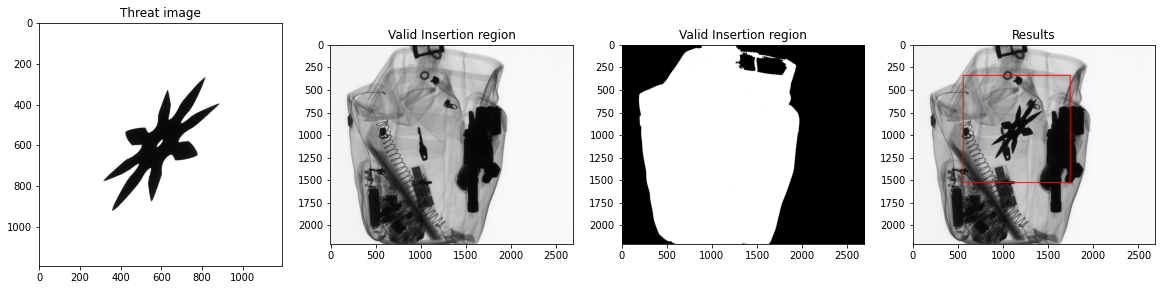

In [66]:
     
temp_back = background.copy()
# bbox = [(x[rand_point], y[rand_point]), (img.size)]

temp_back.paste(img, bbox[0], img)
temp_back = rect(temp_back, shape = [bbox[0],bbox[-1]])

figure=plt.figure(figsize=(20,20))
plt.subplot(141)
plt.imshow(img)
plt.title('Threat image')



plt.subplot(142)
plt.imshow(background,cmap='gray')
plt.title('Valid Insertion region')


plt.subplot(143)
plt.imshow(img_eroded,cmap='gray')
plt.title('Valid Insertion region')


plt.subplot(144)
plt.imshow(temp_back)
plt.title('Results')
    
plt.show()

In [34]:
# 30 GANS
# 9 Similar to TIP
# # Superimpose image # Keyword
# 19,23,24,22


# ISSUES.
1. GDXRAY DOESNOT HAVE BENIGN IMAGE
2. The boundingbox appears to be too big

# TODO
1. Generate Synthetic image(before that check the image blending tips in paper and check few more paper on image projection and blending)
2. Test on newer models(de



In [ ]:
# # from PIL import Image
# im1 = Image.open("background.jpg")
# im2 = Image.open("bird.jpg")

# newimg = Image.blend(im1, im2, alpha=0.5)
# newimg.save("blended.jpg")

# Focal loss
# You sent
# for novel model
# You sent

# Retinanet copy Try to remake

# You sent
# Elastic deformation


# You sent
# GAN moght not work due to lack of image
# You sent
# Anchor box
# You sent
# Justin johnson Fei fei le
# You sent
# Efficient net
# You sent
# nsteatead of mobilenet
# You sent
# Deter Transformer model
# You sent
# SSD ma FOCAL length MOBILENET
# You sent
# openmmdate
# You sent
# detectron2
# You sent
# tensorflow objdetection API



<!-- Focal loss
You sent
for novel model
You sent
Retinanet copy Try to remake
You sent
Elastic deformation
You sent
GAN moght not work due to lack of image
You sent
Anchor box
You sent
Justin johnson Fei fei le
You sent
Efficient net
You sent
nsteatead of mobilenet
You sent
Deter Transformer model
You sent
SSD ma FOCAL length MOBILENET
You sent
openmmdate
You sent
detectron2
You sent
tensorflow objdetection API### STEPS -->

1. Threat Signature Transformation
   
     *  Remove image from background with simple thresholding
     *  Rotate by random angle theta
      
      
2. Image position determination
    
    Deterimined based on Bag region and shape of threat signature
    Bag image It --> Morphological operation to extract bag region
        1. original bag image --> Binarised by thresholding to extract foreground(target region) for insertion
            Due to noise, a simple thresholding process cannot ideally separate background and foreground.
            apply a series of appropriately parameterised morphological operations including dilation, hole   
            filling (Figure 3d) and erosion
    
3. Image compositing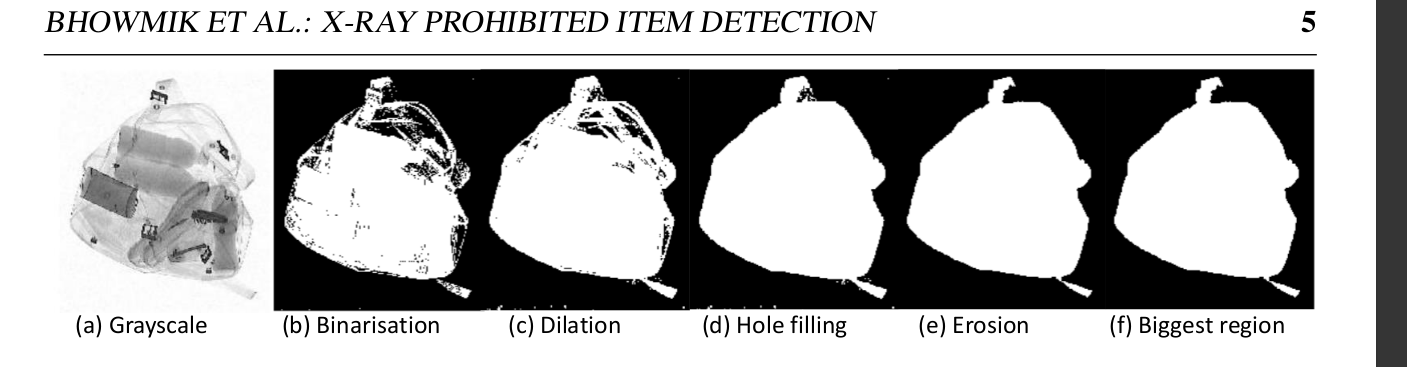